# GANs to create more image samples of skin lesions

In [1]:
# import libraries
import os
import sys
import PIL
import time
import glob
import imageio
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from subprocess import call
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from IPython import display

In [2]:
from google.api_core import page_iterator
from google.cloud import storage
from io import BytesIO

In [4]:
# client = storage.Client()

In [ ]:
bucket_name = 'ai-in-dermatology'

In [5]:
def list_blob(bucket_name: str, prefix: str=None, delimiter: str=None):
    return [blob for blob in client.list_blobs(bucket_name, prefix=prefix, delimiter=delimiter)]

In [6]:
def _item_to_value(iterator, item):
    return item

In [7]:
def list_directories(bucket_name: str, prefix: str):
    if not prefix.endswith('/'):
        prefix += '/'

    extra_params = {
        "projection": "noAcl",
        "prefix": prefix,
        "delimiter": '/'
    }

    gcs = storage.Client()

    path = "/b/" + bucket_name + "/o"

    iterator = page_iterator.HTTPIterator(
        client=gcs,
        api_request=gcs._connection.api_request,
        path=path,
        items_key='prefixes',
        item_to_value=_item_to_value,
        extra_params=extra_params,
    )

    return [x for x in iterator]

In [ ]:
# list_blob(bucket_name)
# list_blob(bucket_name, 'data/train', delimiter=None)

In [ ]:
# dir_lst = list_directories(bucket_name, 'data/train')

In [ ]:
# CLASS_NAMES = [item.split('/')[-2] for item in dir_lst]

In [ ]:
# CLASS_NAMES

In [ ]:
# Load and prepare the dataset

In [ ]:
# get train data
# call(['gsutil', 'cp', '-r', 'gs://{}/data/train'.format(bucket_name), '../data'])

In [ ]:
# get test data
# call(['gsutil', 'cp', '-r', 'gs://{}/data/test'.format(bucket_name), '../data'])

In [8]:
# create a data generator
datagen = ImageDataGenerator()

In [15]:
CLASS_NAMES = np.array([item.name for item in pathlib.Path('../../data/train').glob('*')])

In [16]:
CLASS_NAMES

array(['pityriasis-versicolor', 'kaposi-sarcoma-patch-plaque-nodule',
       'scabies', 'atopic-dermatitis-eczema', 'pityriasis-rosea',
       'lichen-planus', 'mycosis-fungoides-mf-plaque', 'psoriasis',
       'vitiligo', 'mycosis-fungoides-mf-patch',
       'seborrhoeic-dermatitis-eczema', 'mycosis-fungoides-mf-nodular',
       'granuloma-annulare'], dtype='<U34')

In [17]:
BATCH_SIZE = 32
IMG_HEIGHT = 28 #224
IMG_WIDTH = 28 #224
CLASS_SIZE = len(CLASS_NAMES)
# STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [ ]:
# lst_train_dir = list_blob(bucket_name, 'data/train')

In [ ]:
# lst_train_dir

In [ ]:
# lst_test_dir = list_blob(bucket_name, 'data/test')

In [21]:
train_generator = datagen.flow_from_directory(
    '../../data/train_r',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes = list(CLASS_NAMES))

Found 254 images belonging to 13 classes.


In [20]:
test_generator = datagen.flow_from_directory(
    '../../data/test_r',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes = list(CLASS_NAMES))

Found 252 images belonging to 13 classes.


In [ ]:
train_generator.class_indices

In [ ]:
def make_train_generator():
    train_datagen = ImageDataGenerator(rescale=1. / 255)
    train_generator =  
    train_generator = datagen.flow_from_directory(
        '../../data/train_r',
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        classes = list(CLASS_NAMES))
    return train_generator

In [ ]:
# x = next(train_generator)[0]

In [ ]:
# print(x.shape)
# print(x[0].shape)
# (32, 28, 28, 3)

In [ ]:
# plt.imshow((x[3]).astype(np.uint8))
# # plt.imshow((x[3] * 255).astype(np.uint8))
# plt.show()

In [ ]:
# BUFFER_SIZE = 60000
# BATCH_SIZE = 32 #256

In [22]:
# inspect batch
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(18,18))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n].astype(np.uint8))
#         print(CLASS_NAMES[int(label_batch[n])])
        plt.title(CLASS_NAMES[int(label_batch[n])].title())
        plt.axis('off')

In [ ]:
# 224 * 224 images
image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch)

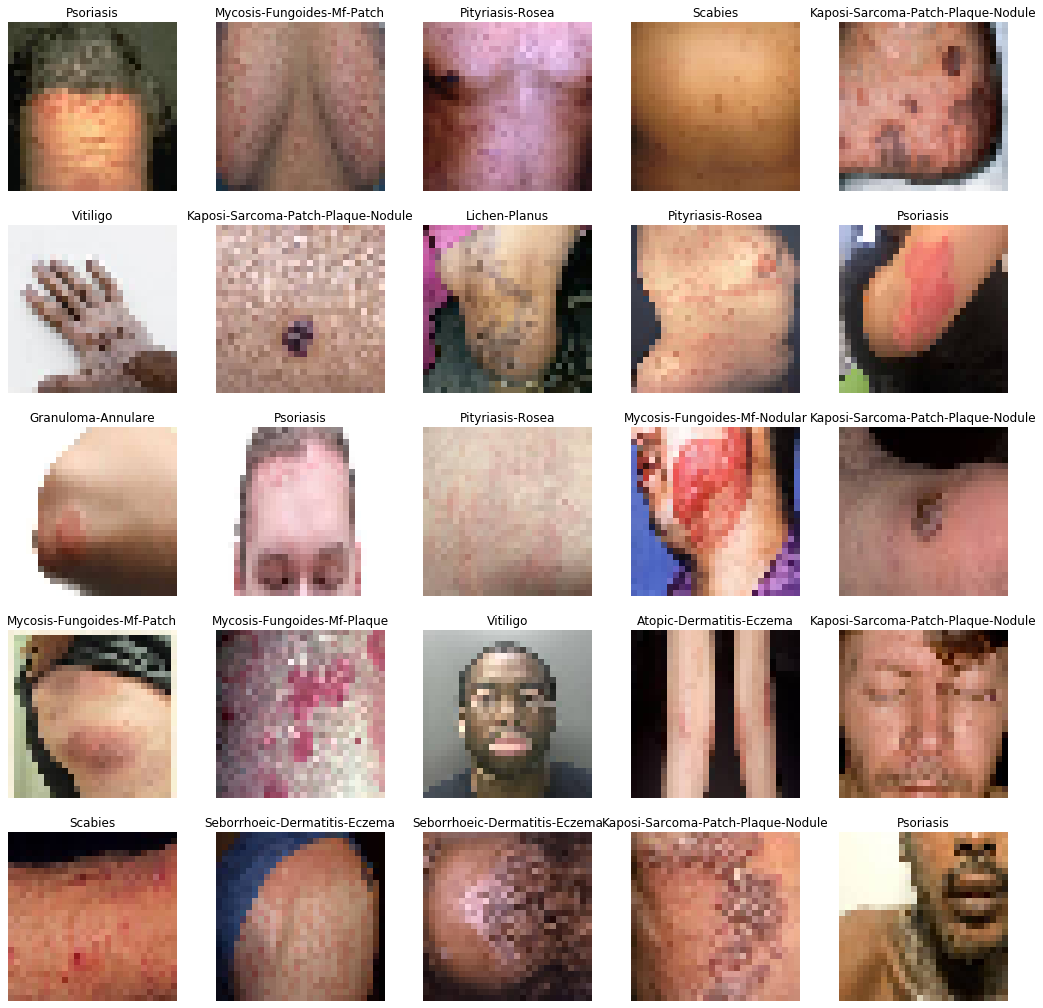

In [23]:
# 28 * 28 images
image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch)

In [24]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_generator(
    lambda: map(tuple, train_generator), output_types=(tf.float32, tf.float32),
    output_shapes=([None, IMG_HEIGHT, IMG_WIDTH, 3], [None])
)
# output_shapes=([BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3], [BATCH_SIZE, CLASS_SIZE])

In [25]:
# generator
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
#     model.add(layers.Dense(256, use_bias=False, input_shape=[IMG_HEIGHT, IMG_WIDTH, 3]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

#     model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 3)

    return model

In [ ]:
# print(7*7*256)
# print(28*28)

In [ ]:
# create an image with untrained generator

In [26]:
generator = make_generator_model()

In [27]:
noise = tf.random.normal([1, 100])
# noise = tf.random.normal([IMG_HEIGHT, IMG_WIDTH, 3])

In [28]:
noise.shape

TensorShape([1, 100])

In [29]:
# generator.trainable

In [30]:
generated_image = generator(noise, training=False)

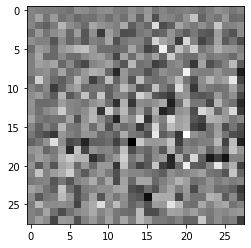

In [31]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

In [32]:
# discriminator
def make_discriminator_model():
    model = tf.keras.Sequential()
#     model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
#                                      input_shape=[28, 28, 1]))
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[IMG_HEIGHT, IMG_WIDTH, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [33]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.0026418]], shape=(1, 1), dtype=float32)


In [34]:
# Define the loss and optimizers

In [35]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [36]:
# discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [37]:
# generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [38]:
# The discriminator and the generator optimizers are different since we will train two networks separately.

In [39]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [40]:
# Save checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [41]:
# Define the training loop

In [42]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [43]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [44]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

    for image_batch in dataset:
        train_step(image_batch[0])

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [45]:
# generate and save images

In [46]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [47]:
# train the model

In [ ]:
# it = iter(train_dataset)

In [ ]:
# batch = next(it)

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
2+2